**Problem Statement**

Mengary is an online E-Commerce company that delivers goods to its customers all over the U.S.A (similar to Amazon). The 3 subsidiary companies under it namely Kariox, Fynota, and Qexty sell products in the Electronics, Food & Beverage, and Clothing Industry segment, respectively. The CEO and the board of directors of the parent company have been excessively worried about the profits for the present year considering their profits were not great last financial year. They wish to predict the profits on each product of the subsidiary companies so that they can adjust the discount given on the loss-making products. But since they don’t know which products are going to produce loss, the management has decided to hire you and your team to help predict the profit for the upcoming financial year. It's almost the end of the financial year 2020-2021 and the data of all the order placement dates and delivery dates(including other features) are known to the company beforehand.

**Objective**

Your task is to predict the profits for the remainder of the year 2021 (April to December). The board members have put in a lot of trust in you to accurately predict the profits for the remainder of this year so that they can increase their revenue.

**Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

**Importing Training and Testing Datasets**

In [2]:
train = pd.read_csv('train.csv')
train.head()

,id,departure city,discount,price,no of items,location,class,segment,sub-class,delivery type,RID,profit,delivery date,address code,departure state,placement date
0,1,Houston,0.2,16.448,2,Central,kariox,Consumer,phone,Standard Class,7981,5.5512,2018-01-01,77095,Texas,2018-01-01
1,2,Westland,0.0,29.700,5,Central,kariox,Consumer,headset,Standard Class,6334,13.3650,2018-01-01,48185,Michigan,2018-01-01
2,3,Westland,0.0,14.730,3,Central,qexty,Consumer,shorts,Standard Class,6333,4.8609,2018-01-01,48185,Michigan,2018-01-01
3,4,Westland,0.0,43.920,3,Central,kariox,Consumer,television,Standard Class,6332,12.7368,2018-01-01,48185,Michigan,2018-01-01
4,5,Westland,0.0,66.580,2,Central,kariox,Consumer,laptop,Standard Class,6331,15.9792,2018-01-01,48185,Michigan,2018-01-01


In [3]:
test = pd.read_csv('test.csv')
test.head()

,id,departure city,discount,price,no of items,location,class,segment,sub-class,delivery type,RID,delivery date,address code,departure state,placement date
0,6701,San Francisco,0.0,24.200,5,West,kariox,Consumer,television,Standard Class,2408,2021-01-01,94122,California,2021-01-01
1,6702,San Francisco,0.2,359.976,3,West,fynota,Consumer,colddrinks,Standard Class,2409,2021-01-01,94122,California,2021-01-01
2,6703,Waterbury,0.0,3.520,2,East,kariox,Consumer,television,Standard Class,5425,2021-01-01,6708,Connecticut,2021-01-01
3,6704,Chicago,0.2,11.520,5,Central,kariox,Consumer,tablet,First Class,7408,2021-01-01,60653,Illinois,2021-01-01
4,6705,Seattle,0.0,242.940,3,West,kariox,Home Office,laptop,Standard Class,733,2021-01-01,98115,Washington,2021-01-01


**Exploratory Data Analysis**

*Filling null values* 

In [4]:
train['delivery type'].fillna(value = train['delivery type'].mode()[0], inplace=True)

*Merging Datasets to apply transformations*

In [5]:
# adding the source of the data to make it easy to separate data after the transformations are done
train['Source'] = 'train' 
test['Source'] = 'test'

In [6]:
# merging the datasets
data = pd.concat([train,test])

In [7]:
# looking for the number of unique values for each feature
data.nunique()

id                 9994
departure city      531
discount             12
price              5825
no of items          14
location              4
class                 3
segment               3
sub-class            17
delivery type         4
RID                9994
profit             5285
delivery date        49
address code        631
departure state      49
placement date       48
Source                2
dtype: int64

In [8]:
# Looking at how the numerical data is distributed
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,9994.0,4997.500000,2885.163629,1.000,2499.25000,4997.5000,7495.7500,9994.000
discount,9994.0,0.156203,0.206452,0.000,0.00000,0.2000,0.2000,0.800
price,9994.0,229.858001,623.245101,0.444,17.28000,54.4900,209.9400,22638.480
no of items,9994.0,3.789574,2.225110,1.000,2.00000,3.0000,5.0000,14.000
RID,9994.0,4997.500000,2885.163629,1.000,2499.25000,4997.5000,7495.7500,9994.000
profit,6700.0,29.121046,230.712951,-6599.978,1.71375,8.8032,30.0234,8399.976
address code,9994.0,55190.379428,32063.693350,1040.000,23223.00000,56430.5000,90008.0000,99301.000


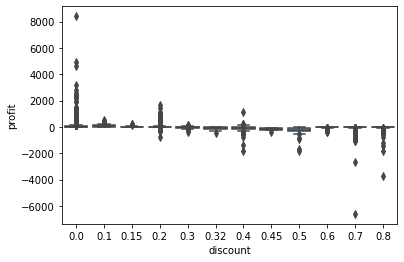

--------------------------------------------------------------------------------




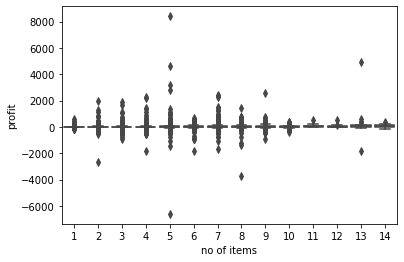

--------------------------------------------------------------------------------




In [9]:
# Identifying if outliers exist
for i in ['discount', 'no of items']:
    sns.boxplot(x = i, y = 'profit', data = train)
    plt.show()
    print('--------'*10)
    print('\n')

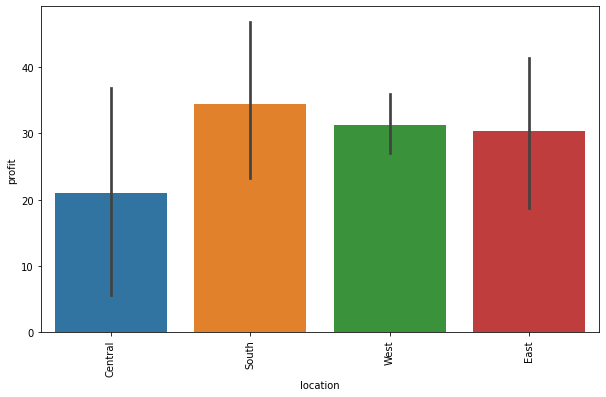

--------------------------------------------------------------------------------




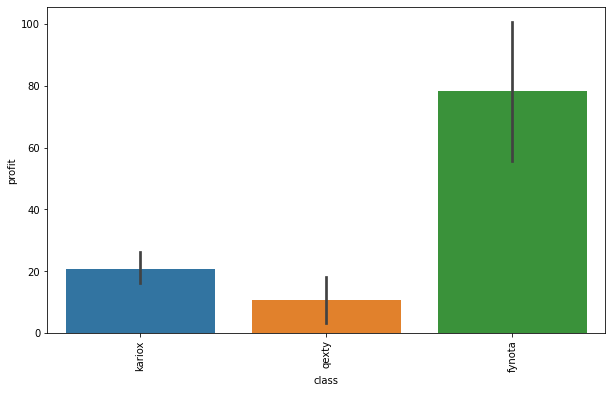

--------------------------------------------------------------------------------




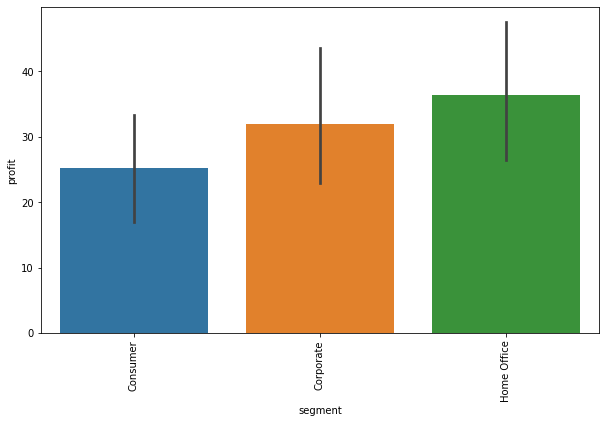

--------------------------------------------------------------------------------




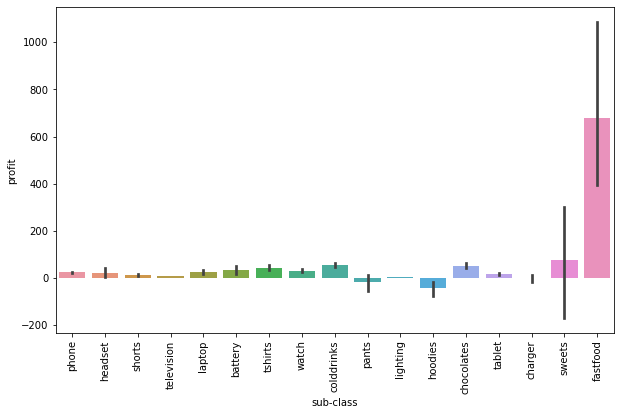

--------------------------------------------------------------------------------




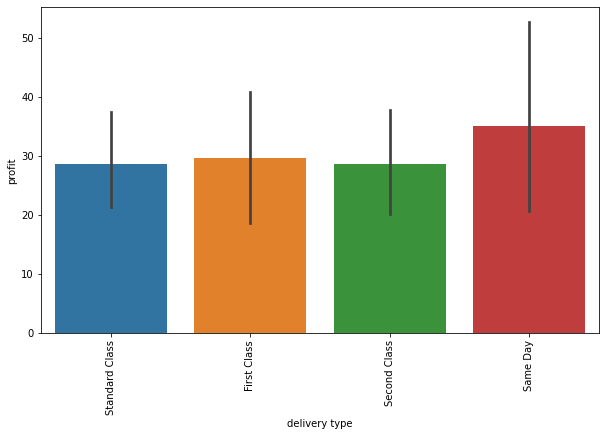

--------------------------------------------------------------------------------




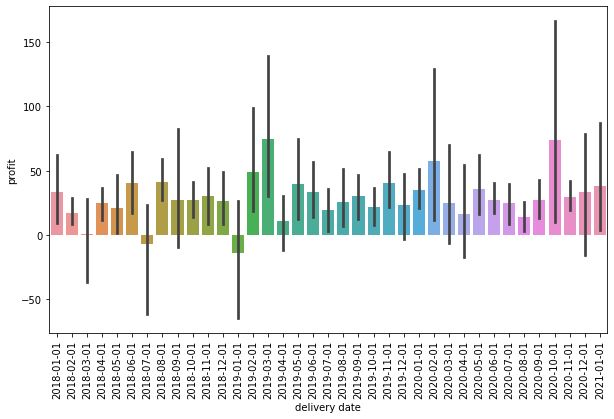

--------------------------------------------------------------------------------




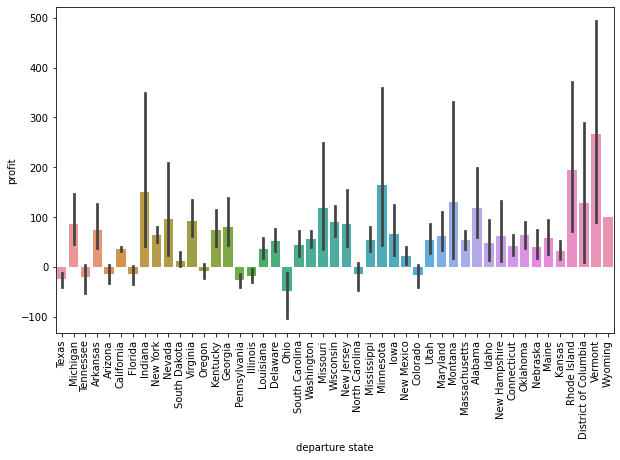

--------------------------------------------------------------------------------




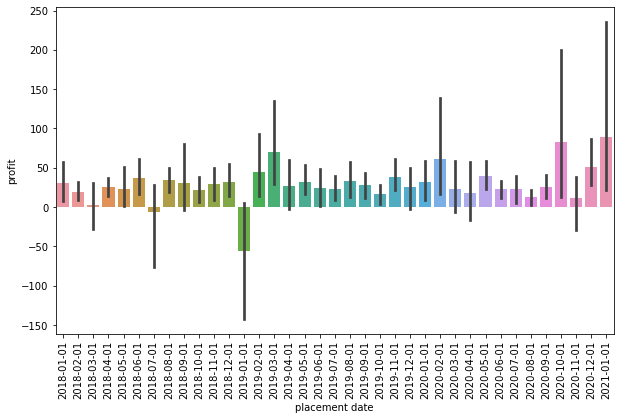

--------------------------------------------------------------------------------




In [10]:
# Exploring relation between categorical data and profit
for i in data.select_dtypes(object).columns[1:-1]:
    plt.figure(figsize=(10,6))
    sns.barplot(x = i, y = 'profit', data = train)
    plt.xticks(rotation=90)
    plt.show()
    print('--------'*10)
    print('\n')

**Feature Engineering**

In [11]:
# Making a new feature delivery time to measure the time between delivery and placement of order.
data['delivery date'] = pd.to_datetime(data['delivery date'])
data['placement date'] = pd.to_datetime(data['placement date'])
data['delivery time'] = (data['delivery date'] - data['placement date']).dt.days
data.drop(columns = ['delivery date','placement date'], inplace = True)

In [12]:
# One hot encoding all categorical data along with address code since it does not serve any purpose as numerical data
columns = ['departure city', 'location', 'class', 'delivery type', 'address code','segment', 'sub-class', 'departure state']
data_dummy = pd.get_dummies(data,drop_first=True,columns=columns)

In [13]:
data_dummy.head()

,id,discount,price,no of items,RID,profit,Source,delivery time,departure city_Abilene,departure city_Akron,...,departure state_South Dakota,departure state_Tennessee,departure state_Texas,departure state_Utah,departure state_Vermont,departure state_Virginia,departure state_Washington,departure state_West Virginia,departure state_Wisconsin,departure state_Wyoming
0,1,0.2,16.448,2,7981,5.5512,train,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,2,0.0,29.700,5,6334,13.3650,train,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0.0,14.730,3,6333,4.8609,train,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0.0,43.920,3,6332,12.7368,train,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0.0,66.580,2,6331,15.9792,train,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
data_dummy.columns

Index(['id', 'discount', 'price', 'no of items', 'RID', 'profit', 'Source',
       'delivery time', 'departure city_Abilene', 'departure city_Akron',
       ...
       'departure state_South Dakota', 'departure state_Tennessee',
       'departure state_Texas', 'departure state_Utah',
       'departure state_Vermont', 'departure state_Virginia',
       'departure state_Washington', 'departure state_West Virginia',
       'departure state_Wisconsin', 'departure state_Wyoming'],
      dtype='object', length=1242)

In [16]:
# Taking an inverse of the delivery time 
data_dummy['delivery time'] = data_dummy['delivery time'].apply(lambda x: 1/(x+1))

In [17]:
# Splitting the data back into training and testing data and dropping id,source and RID columns
traind = data_dummy[data_dummy['Source']=='train']
testd = data_dummy[data_dummy['Source']=='test']
traind.drop(columns = ['Source','id','RID'], inplace = True)
testd.drop(columns = ['Source','id','RID','profit'], inplace = True)

C:\ProgramData\Anaconda3\envs\tf_keras\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [18]:
traind.head()

,discount,price,no of items,profit,delivery time,departure city_Abilene,departure city_Akron,departure city_Albuquerque,departure city_Alexandria,departure city_Allen,...,departure state_South Dakota,departure state_Tennessee,departure state_Texas,departure state_Utah,departure state_Vermont,departure state_Virginia,departure state_Washington,departure state_West Virginia,departure state_Wisconsin,departure state_Wyoming
0,0.2,16.448,2,5.5512,1.0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0.0,29.700,5,13.3650,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,14.730,3,4.8609,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,43.920,3,12.7368,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,66.580,2,15.9792,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Scaling the features apart from profit since it's the target feature
scaler = MinMaxScaler()
columns = traind.drop(columns= 'profit').columns

In [20]:
training = scaler.fit_transform(traind.drop(columns= 'profit'))
training = pd.DataFrame(training, columns= columns)
training.head()

,discount,price,no of items,delivery time,departure city_Abilene,departure city_Akron,departure city_Albuquerque,departure city_Alexandria,departure city_Allen,departure city_Allentown,...,departure state_South Dakota,departure state_Tennessee,departure state_Texas,departure state_Utah,departure state_Vermont,departure state_Virginia,departure state_Washington,departure state_West Virginia,departure state_Wisconsin,departure state_Wyoming
0,0.25,0.000690,0.076923,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00,0.001275,0.307692,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00,0.000614,0.153846,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00,0.001903,0.153846,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00,0.002904,0.076923,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
testing = scaler.transform(testd)
testing = pd.DataFrame(testing, columns= columns)
testing.head()

,discount,price,no of items,delivery time,departure city_Abilene,departure city_Akron,departure city_Albuquerque,departure city_Alexandria,departure city_Allen,departure city_Allentown,...,departure state_South Dakota,departure state_Tennessee,departure state_Texas,departure state_Utah,departure state_Vermont,departure state_Virginia,departure state_Washington,departure state_West Virginia,departure state_Wisconsin,departure state_Wyoming
0,0.00,0.001032,0.307692,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.25,0.015865,0.153846,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00,0.000119,0.076923,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.25,0.000472,0.307692,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00,0.010695,0.153846,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [22]:
# Splitting the training data into training and validation data
X_train, X_val, y_train, y_val = train_test_split(training, traind['profit'],test_size=0.15)

**Feature Selection using Lasso Regression and Decision Tree**

*Lasso Regression*

In [23]:
lasso = Lasso()
lasso.fit(X_train,y_train)

Lasso()

In [24]:
print('The accuracy score is {:.2f} and the r2 score is {:.2f} on training data'.format(lasso.score(X_train,y_train),
                                                                                    r2_score(y_train,lasso.predict(X_train))))

The accuracy score is 0.27 and the r2 score is 0.27 on training data


In [25]:
print('The accuracy score is {:.2f} and the r2 score is {:.2f} on training data'.format(lasso.score(X_val,y_val),
                                                                                        r2_score(y_val,lasso.predict(X_val))))

The accuracy score is 0.35 and the r2 score is 0.35 on training data


In [26]:
# Making a list of features with coeffient as 0
drop_columns = X_train.columns[lasso.coef_==0]
drop_columns

Index(['no of items', 'departure city_Abilene', 'departure city_Akron',
       'departure city_Albuquerque', 'departure city_Alexandria',
       'departure city_Allen', 'departure city_Allentown',
       'departure city_Altoona', 'departure city_Amarillo',
       'departure city_Anaheim',
       ...
       'departure state_South Dakota', 'departure state_Tennessee',
       'departure state_Texas', 'departure state_Utah',
       'departure state_Vermont', 'departure state_Virginia',
       'departure state_Washington', 'departure state_West Virginia',
       'departure state_Wisconsin', 'departure state_Wyoming'],
      dtype='object', length=1219)

In [27]:
# dropping features with coeffient as 0
X_train.drop(columns = drop_columns, inplace= True)
X_val.drop(columns = drop_columns, inplace= True)

C:\ProgramData\Anaconda3\envs\tf_keras\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [28]:
testing.drop(columns = drop_columns, inplace= True)

*DecisionTreeRegression*

In [29]:
dtree = DecisionTreeRegressor()
dtree.fit(X_train,y_train)
dtree.score(X_train,y_train)

0.9999344168063566

In [30]:
r2_score(y_val, dtree.predict(X_val))

0.49325747038211787

In [31]:
importance = pd.DataFrame(100*dtree.feature_importances_,index= X_train.columns,columns=['Importance'])

In [32]:
print(importance.sort_values(by='Importance', ascending = False))

                            Importance
price                        43.218680
discount                     41.765221
sub-class_fastfood            7.712420
departure state_California    1.940152
location_East                 1.511701
sub-class_headset             1.183929
class_qexty                   0.817271
class_kariox                  0.520331
sub-class_laptop              0.448873
sub-class_hoodies             0.282238
address code_78207            0.204999
delivery time                 0.152264
location_West                 0.123237
segment_Corporate             0.103891
sub-class_pants               0.007547
departure city_Lancaster      0.004151
departure city_San Antonio    0.003047
address code_47905            0.000025
address code_43130            0.000021


In [33]:
sum(importance['Importance']==0)

0

In [34]:
# Making a list of top 10 important features
columns_keep = importance.sort_values(by='Importance', ascending = False)[:10].index.values

In [35]:
# keeping only the top 10 features
X_train = X_train.loc[:,columns_keep]
X_val = X_val.loc[:,columns_keep]

In [36]:
testing = testing.loc[:,columns_keep]

In [37]:
X_train.shape

(5695, 10)

**Building and Training ANN model**

*Initializing*

In [38]:
ann = tf.keras.models.Sequential()

*Adding input and the first hidden layer*

In [39]:
ann.add(tf.keras.layers.Dense(units=264, activation = 'relu'))

*Adding more hidden layers*

In [40]:
ann.add(tf.keras.layers.Dense(units=164, activation = 'relu'))
ann.add(tf.keras.layers.Dense(units=64, activation = 'relu'))
ann.add(tf.keras.layers.Dense(units=32, activation = 'relu'))

*Adding output layer*

In [41]:
ann.add(tf.keras.layers.Dense(units=1))

**Training ANN**

*Compiling the ANN*

In [42]:
ann.compile(optimizer= 'adam', loss= 'mse', metrics = ['mse'])

*Training the ANN on the training set with early stopping and modelcheckpoint*

In [43]:
es = EarlyStopping(monitor='val_mse', mode='min', verbose=1, patience=1500)
mc = ModelCheckpoint('best_model.h5', monitor='val_mse', mode='min', verbose=1, save_best_only=True)
history = ann.fit(X_train, y_train, validation_data=(X_val, y_val), 
                  epochs=10000, batch_size= 264, verbose=0, callbacks=[es, mc])


Epoch 00001: val_mse improved from inf to 36625.92578, saving model to best_model.h5

Epoch 00002: val_mse improved from 36625.92578 to 35820.06641, saving model to best_model.h5

Epoch 00003: val_mse improved from 35820.06641 to 34329.72656, saving model to best_model.h5

Epoch 00004: val_mse improved from 34329.72656 to 32741.44141, saving model to best_model.h5

Epoch 00005: val_mse improved from 32741.44141 to 31149.88477, saving model to best_model.h5

Epoch 00006: val_mse improved from 31149.88477 to 30227.30469, saving model to best_model.h5

Epoch 00007: val_mse improved from 30227.30469 to 29431.55078, saving model to best_model.h5

Epoch 00008: val_mse improved from 29431.55078 to 28633.34961, saving model to best_model.h5

Epoch 00009: val_mse improved from 28633.34961 to 28255.14062, saving model to best_model.h5

Epoch 00010: val_mse improved from 28255.14062 to 27403.12305, saving model to best_model.h5

Epoch 00011: val_mse improved from 27403.12305 to 26508.37891, savi


Epoch 00103: val_mse improved from 4027.43774 to 3781.63599, saving model to best_model.h5

Epoch 00104: val_mse did not improve from 3781.63599

Epoch 00105: val_mse did not improve from 3781.63599

Epoch 00106: val_mse did not improve from 3781.63599

Epoch 00107: val_mse improved from 3781.63599 to 3746.58105, saving model to best_model.h5

Epoch 00108: val_mse improved from 3746.58105 to 3460.95825, saving model to best_model.h5

Epoch 00109: val_mse did not improve from 3460.95825

Epoch 00110: val_mse improved from 3460.95825 to 3452.90186, saving model to best_model.h5

Epoch 00111: val_mse did not improve from 3452.90186

Epoch 00112: val_mse did not improve from 3452.90186

Epoch 00113: val_mse improved from 3452.90186 to 3426.10107, saving model to best_model.h5

Epoch 00114: val_mse improved from 3426.10107 to 3222.45801, saving model to best_model.h5

Epoch 00115: val_mse did not improve from 3222.45801

Epoch 00116: val_mse did not improve from 3222.45801

Epoch 00117: va


Epoch 00239: val_mse did not improve from 1972.54895

Epoch 00240: val_mse did not improve from 1972.54895

Epoch 00241: val_mse did not improve from 1972.54895

Epoch 00242: val_mse did not improve from 1972.54895

Epoch 00243: val_mse did not improve from 1972.54895

Epoch 00244: val_mse did not improve from 1972.54895

Epoch 00245: val_mse did not improve from 1972.54895

Epoch 00246: val_mse did not improve from 1972.54895

Epoch 00247: val_mse did not improve from 1972.54895

Epoch 00248: val_mse did not improve from 1972.54895

Epoch 00249: val_mse did not improve from 1972.54895

Epoch 00250: val_mse did not improve from 1972.54895

Epoch 00251: val_mse did not improve from 1972.54895

Epoch 00252: val_mse did not improve from 1972.54895

Epoch 00253: val_mse did not improve from 1972.54895

Epoch 00254: val_mse did not improve from 1972.54895

Epoch 00255: val_mse did not improve from 1972.54895

Epoch 00256: val_mse did not improve from 1972.54895

Epoch 00257: val_mse did no


Epoch 00391: val_mse improved from 1963.09473 to 1911.06226, saving model to best_model.h5

Epoch 00392: val_mse did not improve from 1911.06226

Epoch 00393: val_mse did not improve from 1911.06226

Epoch 00394: val_mse did not improve from 1911.06226

Epoch 00395: val_mse did not improve from 1911.06226

Epoch 00396: val_mse did not improve from 1911.06226

Epoch 00397: val_mse did not improve from 1911.06226

Epoch 00398: val_mse did not improve from 1911.06226

Epoch 00399: val_mse did not improve from 1911.06226

Epoch 00400: val_mse did not improve from 1911.06226

Epoch 00401: val_mse did not improve from 1911.06226

Epoch 00402: val_mse did not improve from 1911.06226

Epoch 00403: val_mse did not improve from 1911.06226

Epoch 00404: val_mse did not improve from 1911.06226

Epoch 00405: val_mse did not improve from 1911.06226

Epoch 00406: val_mse did not improve from 1911.06226

Epoch 00407: val_mse did not improve from 1911.06226

Epoch 00408: val_mse did not improve from 1


Epoch 00543: val_mse did not improve from 1893.90125

Epoch 00544: val_mse did not improve from 1893.90125

Epoch 00545: val_mse did not improve from 1893.90125

Epoch 00546: val_mse did not improve from 1893.90125

Epoch 00547: val_mse did not improve from 1893.90125

Epoch 00548: val_mse did not improve from 1893.90125

Epoch 00549: val_mse did not improve from 1893.90125

Epoch 00550: val_mse did not improve from 1893.90125

Epoch 00551: val_mse did not improve from 1893.90125

Epoch 00552: val_mse did not improve from 1893.90125

Epoch 00553: val_mse did not improve from 1893.90125

Epoch 00554: val_mse did not improve from 1893.90125

Epoch 00555: val_mse did not improve from 1893.90125

Epoch 00556: val_mse did not improve from 1893.90125

Epoch 00557: val_mse did not improve from 1893.90125

Epoch 00558: val_mse did not improve from 1893.90125

Epoch 00559: val_mse did not improve from 1893.90125

Epoch 00560: val_mse did not improve from 1893.90125

Epoch 00561: val_mse did no


Epoch 00695: val_mse did not improve from 1845.89478

Epoch 00696: val_mse did not improve from 1845.89478

Epoch 00697: val_mse did not improve from 1845.89478

Epoch 00698: val_mse did not improve from 1845.89478

Epoch 00699: val_mse did not improve from 1845.89478

Epoch 00700: val_mse did not improve from 1845.89478

Epoch 00701: val_mse did not improve from 1845.89478

Epoch 00702: val_mse did not improve from 1845.89478

Epoch 00703: val_mse did not improve from 1845.89478

Epoch 00704: val_mse did not improve from 1845.89478

Epoch 00705: val_mse did not improve from 1845.89478

Epoch 00706: val_mse did not improve from 1845.89478

Epoch 00707: val_mse did not improve from 1845.89478

Epoch 00708: val_mse did not improve from 1845.89478

Epoch 00709: val_mse did not improve from 1845.89478

Epoch 00710: val_mse did not improve from 1845.89478

Epoch 00711: val_mse did not improve from 1845.89478

Epoch 00712: val_mse did not improve from 1845.89478

Epoch 00713: val_mse did no


Epoch 00847: val_mse did not improve from 1815.49902

Epoch 00848: val_mse did not improve from 1815.49902

Epoch 00849: val_mse did not improve from 1815.49902

Epoch 00850: val_mse did not improve from 1815.49902

Epoch 00851: val_mse did not improve from 1815.49902

Epoch 00852: val_mse did not improve from 1815.49902

Epoch 00853: val_mse did not improve from 1815.49902

Epoch 00854: val_mse did not improve from 1815.49902

Epoch 00855: val_mse did not improve from 1815.49902

Epoch 00856: val_mse did not improve from 1815.49902

Epoch 00857: val_mse did not improve from 1815.49902

Epoch 00858: val_mse did not improve from 1815.49902

Epoch 00859: val_mse did not improve from 1815.49902

Epoch 00860: val_mse did not improve from 1815.49902

Epoch 00861: val_mse did not improve from 1815.49902

Epoch 00862: val_mse did not improve from 1815.49902

Epoch 00863: val_mse did not improve from 1815.49902

Epoch 00864: val_mse did not improve from 1815.49902

Epoch 00865: val_mse did no


Epoch 01002: val_mse did not improve from 1815.49902

Epoch 01003: val_mse did not improve from 1815.49902

Epoch 01004: val_mse did not improve from 1815.49902

Epoch 01005: val_mse did not improve from 1815.49902

Epoch 01006: val_mse did not improve from 1815.49902

Epoch 01007: val_mse did not improve from 1815.49902

Epoch 01008: val_mse did not improve from 1815.49902

Epoch 01009: val_mse did not improve from 1815.49902

Epoch 01010: val_mse did not improve from 1815.49902

Epoch 01011: val_mse did not improve from 1815.49902

Epoch 01012: val_mse did not improve from 1815.49902

Epoch 01013: val_mse did not improve from 1815.49902

Epoch 01014: val_mse did not improve from 1815.49902

Epoch 01015: val_mse did not improve from 1815.49902

Epoch 01016: val_mse did not improve from 1815.49902

Epoch 01017: val_mse did not improve from 1815.49902

Epoch 01018: val_mse did not improve from 1815.49902

Epoch 01019: val_mse did not improve from 1815.49902

Epoch 01020: val_mse did no


Epoch 01154: val_mse did not improve from 1795.74854

Epoch 01155: val_mse did not improve from 1795.74854

Epoch 01156: val_mse did not improve from 1795.74854

Epoch 01157: val_mse did not improve from 1795.74854

Epoch 01158: val_mse did not improve from 1795.74854

Epoch 01159: val_mse did not improve from 1795.74854

Epoch 01160: val_mse did not improve from 1795.74854

Epoch 01161: val_mse did not improve from 1795.74854

Epoch 01162: val_mse did not improve from 1795.74854

Epoch 01163: val_mse did not improve from 1795.74854

Epoch 01164: val_mse did not improve from 1795.74854

Epoch 01165: val_mse did not improve from 1795.74854

Epoch 01166: val_mse did not improve from 1795.74854

Epoch 01167: val_mse did not improve from 1795.74854

Epoch 01168: val_mse did not improve from 1795.74854

Epoch 01169: val_mse did not improve from 1795.74854

Epoch 01170: val_mse did not improve from 1795.74854

Epoch 01171: val_mse did not improve from 1795.74854

Epoch 01172: val_mse did no


Epoch 01306: val_mse did not improve from 1783.17615

Epoch 01307: val_mse did not improve from 1783.17615

Epoch 01308: val_mse did not improve from 1783.17615

Epoch 01309: val_mse did not improve from 1783.17615

Epoch 01310: val_mse did not improve from 1783.17615

Epoch 01311: val_mse did not improve from 1783.17615

Epoch 01312: val_mse did not improve from 1783.17615

Epoch 01313: val_mse did not improve from 1783.17615

Epoch 01314: val_mse did not improve from 1783.17615

Epoch 01315: val_mse did not improve from 1783.17615

Epoch 01316: val_mse did not improve from 1783.17615

Epoch 01317: val_mse did not improve from 1783.17615

Epoch 01318: val_mse did not improve from 1783.17615

Epoch 01319: val_mse did not improve from 1783.17615

Epoch 01320: val_mse did not improve from 1783.17615

Epoch 01321: val_mse did not improve from 1783.17615

Epoch 01322: val_mse did not improve from 1783.17615

Epoch 01323: val_mse did not improve from 1783.17615

Epoch 01324: val_mse did no


Epoch 01456: val_mse did not improve from 1740.61267

Epoch 01457: val_mse did not improve from 1740.61267

Epoch 01458: val_mse did not improve from 1740.61267

Epoch 01459: val_mse did not improve from 1740.61267

Epoch 01460: val_mse did not improve from 1740.61267

Epoch 01461: val_mse did not improve from 1740.61267

Epoch 01462: val_mse did not improve from 1740.61267

Epoch 01463: val_mse did not improve from 1740.61267

Epoch 01464: val_mse did not improve from 1740.61267

Epoch 01465: val_mse did not improve from 1740.61267

Epoch 01466: val_mse did not improve from 1740.61267

Epoch 01467: val_mse did not improve from 1740.61267

Epoch 01468: val_mse improved from 1740.61267 to 1739.20569, saving model to best_model.h5

Epoch 01469: val_mse did not improve from 1739.20569

Epoch 01470: val_mse did not improve from 1739.20569

Epoch 01471: val_mse did not improve from 1739.20569

Epoch 01472: val_mse did not improve from 1739.20569

Epoch 01473: val_mse did not improve from 1


Epoch 01605: val_mse did not improve from 1704.07104

Epoch 01606: val_mse did not improve from 1704.07104

Epoch 01607: val_mse did not improve from 1704.07104

Epoch 01608: val_mse did not improve from 1704.07104

Epoch 01609: val_mse did not improve from 1704.07104

Epoch 01610: val_mse did not improve from 1704.07104

Epoch 01611: val_mse did not improve from 1704.07104

Epoch 01612: val_mse did not improve from 1704.07104

Epoch 01613: val_mse did not improve from 1704.07104

Epoch 01614: val_mse did not improve from 1704.07104

Epoch 01615: val_mse did not improve from 1704.07104

Epoch 01616: val_mse did not improve from 1704.07104

Epoch 01617: val_mse did not improve from 1704.07104

Epoch 01618: val_mse did not improve from 1704.07104

Epoch 01619: val_mse did not improve from 1704.07104

Epoch 01620: val_mse did not improve from 1704.07104

Epoch 01621: val_mse did not improve from 1704.07104

Epoch 01622: val_mse did not improve from 1704.07104

Epoch 01623: val_mse did no


Epoch 01759: val_mse did not improve from 1687.35986

Epoch 01760: val_mse did not improve from 1687.35986

Epoch 01761: val_mse did not improve from 1687.35986

Epoch 01762: val_mse did not improve from 1687.35986

Epoch 01763: val_mse did not improve from 1687.35986

Epoch 01764: val_mse did not improve from 1687.35986

Epoch 01765: val_mse did not improve from 1687.35986

Epoch 01766: val_mse did not improve from 1687.35986

Epoch 01767: val_mse did not improve from 1687.35986

Epoch 01768: val_mse did not improve from 1687.35986

Epoch 01769: val_mse did not improve from 1687.35986

Epoch 01770: val_mse did not improve from 1687.35986

Epoch 01771: val_mse did not improve from 1687.35986

Epoch 01772: val_mse did not improve from 1687.35986

Epoch 01773: val_mse did not improve from 1687.35986

Epoch 01774: val_mse did not improve from 1687.35986

Epoch 01775: val_mse did not improve from 1687.35986

Epoch 01776: val_mse did not improve from 1687.35986

Epoch 01777: val_mse did no


Epoch 01912: val_mse did not improve from 1687.35986

Epoch 01913: val_mse did not improve from 1687.35986

Epoch 01914: val_mse did not improve from 1687.35986

Epoch 01915: val_mse did not improve from 1687.35986

Epoch 01916: val_mse did not improve from 1687.35986

Epoch 01917: val_mse did not improve from 1687.35986

Epoch 01918: val_mse did not improve from 1687.35986

Epoch 01919: val_mse did not improve from 1687.35986

Epoch 01920: val_mse did not improve from 1687.35986

Epoch 01921: val_mse did not improve from 1687.35986

Epoch 01922: val_mse did not improve from 1687.35986

Epoch 01923: val_mse did not improve from 1687.35986

Epoch 01924: val_mse did not improve from 1687.35986

Epoch 01925: val_mse did not improve from 1687.35986

Epoch 01926: val_mse did not improve from 1687.35986

Epoch 01927: val_mse did not improve from 1687.35986

Epoch 01928: val_mse did not improve from 1687.35986

Epoch 01929: val_mse did not improve from 1687.35986

Epoch 01930: val_mse did no

Epoch 02064: val_mse did not improve from 1687.35986

Epoch 02065: val_mse did not improve from 1687.35986

Epoch 02066: val_mse did not improve from 1687.35986

Epoch 02067: val_mse did not improve from 1687.35986

Epoch 02068: val_mse did not improve from 1687.35986

Epoch 02069: val_mse did not improve from 1687.35986

Epoch 02070: val_mse did not improve from 1687.35986

Epoch 02071: val_mse did not improve from 1687.35986

Epoch 02072: val_mse did not improve from 1687.35986

Epoch 02073: val_mse did not improve from 1687.35986

Epoch 02074: val_mse did not improve from 1687.35986

Epoch 02075: val_mse did not improve from 1687.35986

Epoch 02076: val_mse did not improve from 1687.35986

Epoch 02077: val_mse did not improve from 1687.35986

Epoch 02078: val_mse did not improve from 1687.35986

Epoch 02079: val_mse did not improve from 1687.35986

Epoch 02080: val_mse did not improve from 1687.35986

Epoch 02081: val_mse did not improve from 1687.35986

Epoch 02082: val_mse did not


Epoch 02216: val_mse did not improve from 1687.35986

Epoch 02217: val_mse did not improve from 1687.35986

Epoch 02218: val_mse did not improve from 1687.35986

Epoch 02219: val_mse did not improve from 1687.35986

Epoch 02220: val_mse did not improve from 1687.35986

Epoch 02221: val_mse did not improve from 1687.35986

Epoch 02222: val_mse did not improve from 1687.35986

Epoch 02223: val_mse did not improve from 1687.35986

Epoch 02224: val_mse did not improve from 1687.35986

Epoch 02225: val_mse did not improve from 1687.35986

Epoch 02226: val_mse did not improve from 1687.35986

Epoch 02227: val_mse did not improve from 1687.35986

Epoch 02228: val_mse did not improve from 1687.35986

Epoch 02229: val_mse did not improve from 1687.35986

Epoch 02230: val_mse did not improve from 1687.35986

Epoch 02231: val_mse did not improve from 1687.35986

Epoch 02232: val_mse did not improve from 1687.35986

Epoch 02233: val_mse did not improve from 1687.35986

Epoch 02234: val_mse did no


Epoch 02368: val_mse did not improve from 1687.35986

Epoch 02369: val_mse did not improve from 1687.35986

Epoch 02370: val_mse did not improve from 1687.35986

Epoch 02371: val_mse did not improve from 1687.35986

Epoch 02372: val_mse did not improve from 1687.35986

Epoch 02373: val_mse did not improve from 1687.35986

Epoch 02374: val_mse did not improve from 1687.35986

Epoch 02375: val_mse did not improve from 1687.35986

Epoch 02376: val_mse did not improve from 1687.35986

Epoch 02377: val_mse did not improve from 1687.35986

Epoch 02378: val_mse did not improve from 1687.35986

Epoch 02379: val_mse did not improve from 1687.35986

Epoch 02380: val_mse did not improve from 1687.35986

Epoch 02381: val_mse did not improve from 1687.35986

Epoch 02382: val_mse did not improve from 1687.35986

Epoch 02383: val_mse did not improve from 1687.35986

Epoch 02384: val_mse did not improve from 1687.35986

Epoch 02385: val_mse did not improve from 1687.35986

Epoch 02386: val_mse did no


Epoch 02520: val_mse did not improve from 1687.35986

Epoch 02521: val_mse did not improve from 1687.35986

Epoch 02522: val_mse did not improve from 1687.35986

Epoch 02523: val_mse did not improve from 1687.35986

Epoch 02524: val_mse did not improve from 1687.35986

Epoch 02525: val_mse did not improve from 1687.35986

Epoch 02526: val_mse did not improve from 1687.35986

Epoch 02527: val_mse did not improve from 1687.35986

Epoch 02528: val_mse did not improve from 1687.35986

Epoch 02529: val_mse did not improve from 1687.35986

Epoch 02530: val_mse did not improve from 1687.35986

Epoch 02531: val_mse did not improve from 1687.35986

Epoch 02532: val_mse did not improve from 1687.35986

Epoch 02533: val_mse did not improve from 1687.35986

Epoch 02534: val_mse did not improve from 1687.35986

Epoch 02535: val_mse did not improve from 1687.35986

Epoch 02536: val_mse improved from 1687.35986 to 1673.79102, saving model to best_model.h5

Epoch 02537: val_mse did not improve from 1


Epoch 02673: val_mse did not improve from 1673.79102

Epoch 02674: val_mse did not improve from 1673.79102

Epoch 02675: val_mse did not improve from 1673.79102

Epoch 02676: val_mse did not improve from 1673.79102

Epoch 02677: val_mse did not improve from 1673.79102

Epoch 02678: val_mse did not improve from 1673.79102

Epoch 02679: val_mse did not improve from 1673.79102

Epoch 02680: val_mse did not improve from 1673.79102

Epoch 02681: val_mse did not improve from 1673.79102

Epoch 02682: val_mse did not improve from 1673.79102

Epoch 02683: val_mse did not improve from 1673.79102

Epoch 02684: val_mse did not improve from 1673.79102

Epoch 02685: val_mse did not improve from 1673.79102

Epoch 02686: val_mse did not improve from 1673.79102

Epoch 02687: val_mse did not improve from 1673.79102

Epoch 02688: val_mse did not improve from 1673.79102

Epoch 02689: val_mse did not improve from 1673.79102

Epoch 02690: val_mse did not improve from 1673.79102

Epoch 02691: val_mse did no


Epoch 02826: val_mse did not improve from 1673.79102

Epoch 02827: val_mse did not improve from 1673.79102

Epoch 02828: val_mse did not improve from 1673.79102

Epoch 02829: val_mse did not improve from 1673.79102

Epoch 02830: val_mse did not improve from 1673.79102

Epoch 02831: val_mse did not improve from 1673.79102

Epoch 02832: val_mse did not improve from 1673.79102

Epoch 02833: val_mse did not improve from 1673.79102

Epoch 02834: val_mse did not improve from 1673.79102

Epoch 02835: val_mse did not improve from 1673.79102

Epoch 02836: val_mse did not improve from 1673.79102

Epoch 02837: val_mse did not improve from 1673.79102

Epoch 02838: val_mse did not improve from 1673.79102

Epoch 02839: val_mse did not improve from 1673.79102

Epoch 02840: val_mse did not improve from 1673.79102

Epoch 02841: val_mse did not improve from 1673.79102

Epoch 02842: val_mse did not improve from 1673.79102

Epoch 02843: val_mse did not improve from 1673.79102

Epoch 02844: val_mse did no


Epoch 02979: val_mse did not improve from 1673.79102

Epoch 02980: val_mse did not improve from 1673.79102

Epoch 02981: val_mse did not improve from 1673.79102

Epoch 02982: val_mse did not improve from 1673.79102

Epoch 02983: val_mse did not improve from 1673.79102

Epoch 02984: val_mse did not improve from 1673.79102

Epoch 02985: val_mse did not improve from 1673.79102

Epoch 02986: val_mse did not improve from 1673.79102

Epoch 02987: val_mse did not improve from 1673.79102

Epoch 02988: val_mse did not improve from 1673.79102

Epoch 02989: val_mse did not improve from 1673.79102

Epoch 02990: val_mse did not improve from 1673.79102

Epoch 02991: val_mse did not improve from 1673.79102

Epoch 02992: val_mse did not improve from 1673.79102

Epoch 02993: val_mse did not improve from 1673.79102

Epoch 02994: val_mse did not improve from 1673.79102

Epoch 02995: val_mse did not improve from 1673.79102

Epoch 02996: val_mse did not improve from 1673.79102

Epoch 02997: val_mse did no


Epoch 03132: val_mse did not improve from 1673.79102

Epoch 03133: val_mse did not improve from 1673.79102

Epoch 03134: val_mse did not improve from 1673.79102

Epoch 03135: val_mse did not improve from 1673.79102

Epoch 03136: val_mse did not improve from 1673.79102

Epoch 03137: val_mse did not improve from 1673.79102

Epoch 03138: val_mse did not improve from 1673.79102

Epoch 03139: val_mse did not improve from 1673.79102

Epoch 03140: val_mse did not improve from 1673.79102

Epoch 03141: val_mse did not improve from 1673.79102

Epoch 03142: val_mse did not improve from 1673.79102

Epoch 03143: val_mse did not improve from 1673.79102

Epoch 03144: val_mse did not improve from 1673.79102

Epoch 03145: val_mse did not improve from 1673.79102

Epoch 03146: val_mse did not improve from 1673.79102

Epoch 03147: val_mse did not improve from 1673.79102

Epoch 03148: val_mse did not improve from 1673.79102

Epoch 03149: val_mse did not improve from 1673.79102

Epoch 03150: val_mse did no


Epoch 03284: val_mse did not improve from 1673.79102

Epoch 03285: val_mse did not improve from 1673.79102

Epoch 03286: val_mse did not improve from 1673.79102

Epoch 03287: val_mse did not improve from 1673.79102

Epoch 03288: val_mse did not improve from 1673.79102

Epoch 03289: val_mse did not improve from 1673.79102

Epoch 03290: val_mse did not improve from 1673.79102

Epoch 03291: val_mse did not improve from 1673.79102

Epoch 03292: val_mse did not improve from 1673.79102

Epoch 03293: val_mse did not improve from 1673.79102

Epoch 03294: val_mse did not improve from 1673.79102

Epoch 03295: val_mse did not improve from 1673.79102

Epoch 03296: val_mse did not improve from 1673.79102

Epoch 03297: val_mse did not improve from 1673.79102

Epoch 03298: val_mse did not improve from 1673.79102

Epoch 03299: val_mse did not improve from 1673.79102

Epoch 03300: val_mse did not improve from 1673.79102

Epoch 03301: val_mse did not improve from 1673.79102

Epoch 03302: val_mse did no


Epoch 03436: val_mse did not improve from 1673.79102

Epoch 03437: val_mse did not improve from 1673.79102

Epoch 03438: val_mse did not improve from 1673.79102

Epoch 03439: val_mse did not improve from 1673.79102

Epoch 03440: val_mse did not improve from 1673.79102

Epoch 03441: val_mse did not improve from 1673.79102

Epoch 03442: val_mse did not improve from 1673.79102

Epoch 03443: val_mse did not improve from 1673.79102

Epoch 03444: val_mse did not improve from 1673.79102

Epoch 03445: val_mse did not improve from 1673.79102

Epoch 03446: val_mse did not improve from 1673.79102

Epoch 03447: val_mse did not improve from 1673.79102

Epoch 03448: val_mse did not improve from 1673.79102

Epoch 03449: val_mse did not improve from 1673.79102

Epoch 03450: val_mse did not improve from 1673.79102

Epoch 03451: val_mse did not improve from 1673.79102

Epoch 03452: val_mse did not improve from 1673.79102

Epoch 03453: val_mse did not improve from 1673.79102

Epoch 03454: val_mse did no


Epoch 03590: val_mse did not improve from 1673.79102

Epoch 03591: val_mse did not improve from 1673.79102

Epoch 03592: val_mse did not improve from 1673.79102

Epoch 03593: val_mse did not improve from 1673.79102

Epoch 03594: val_mse did not improve from 1673.79102

Epoch 03595: val_mse did not improve from 1673.79102

Epoch 03596: val_mse did not improve from 1673.79102

Epoch 03597: val_mse did not improve from 1673.79102

Epoch 03598: val_mse did not improve from 1673.79102

Epoch 03599: val_mse did not improve from 1673.79102

Epoch 03600: val_mse did not improve from 1673.79102

Epoch 03601: val_mse did not improve from 1673.79102

Epoch 03602: val_mse did not improve from 1673.79102

Epoch 03603: val_mse did not improve from 1673.79102

Epoch 03604: val_mse did not improve from 1673.79102

Epoch 03605: val_mse did not improve from 1673.79102

Epoch 03606: val_mse did not improve from 1673.79102

Epoch 03607: val_mse did not improve from 1673.79102

Epoch 03608: val_mse did no


Epoch 03742: val_mse did not improve from 1673.79102

Epoch 03743: val_mse did not improve from 1673.79102

Epoch 03744: val_mse did not improve from 1673.79102

Epoch 03745: val_mse did not improve from 1673.79102

Epoch 03746: val_mse did not improve from 1673.79102

Epoch 03747: val_mse did not improve from 1673.79102

Epoch 03748: val_mse did not improve from 1673.79102

Epoch 03749: val_mse did not improve from 1673.79102

Epoch 03750: val_mse did not improve from 1673.79102

Epoch 03751: val_mse did not improve from 1673.79102

Epoch 03752: val_mse did not improve from 1673.79102

Epoch 03753: val_mse did not improve from 1673.79102

Epoch 03754: val_mse did not improve from 1673.79102

Epoch 03755: val_mse did not improve from 1673.79102

Epoch 03756: val_mse did not improve from 1673.79102

Epoch 03757: val_mse did not improve from 1673.79102

Epoch 03758: val_mse did not improve from 1673.79102

Epoch 03759: val_mse did not improve from 1673.79102

Epoch 03760: val_mse did no


Epoch 03896: val_mse did not improve from 1673.79102

Epoch 03897: val_mse did not improve from 1673.79102

Epoch 03898: val_mse did not improve from 1673.79102

Epoch 03899: val_mse did not improve from 1673.79102

Epoch 03900: val_mse did not improve from 1673.79102

Epoch 03901: val_mse did not improve from 1673.79102

Epoch 03902: val_mse did not improve from 1673.79102

Epoch 03903: val_mse did not improve from 1673.79102

Epoch 03904: val_mse did not improve from 1673.79102

Epoch 03905: val_mse did not improve from 1673.79102

Epoch 03906: val_mse did not improve from 1673.79102

Epoch 03907: val_mse did not improve from 1673.79102

Epoch 03908: val_mse did not improve from 1673.79102

Epoch 03909: val_mse did not improve from 1673.79102

Epoch 03910: val_mse did not improve from 1673.79102

Epoch 03911: val_mse did not improve from 1673.79102

Epoch 03912: val_mse did not improve from 1673.79102

Epoch 03913: val_mse did not improve from 1673.79102

Epoch 03914: val_mse did no

**Evaluating the model**

In [44]:
saved_model = tf.keras.models.load_model('best_model.h5') # Saving the best model

<AxesSubplot:>

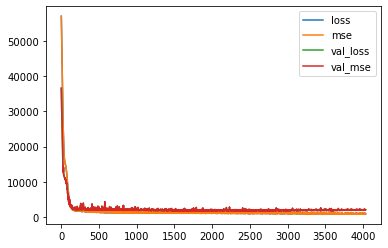

In [45]:
losses = pd.DataFrame(ann.history.history) # Plotting the losses for training and validation data
losses.plot()

In [46]:
_, train_acc = saved_model.evaluate(X_train, y_train, verbose=0) # Saving the mse score for training and validation data
_, test_acc = saved_model.evaluate(X_val, y_val, verbose=0)

In [47]:
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc)) # printing the mse score for training and validation data

Train: 927.816, Test: 1673.791


In [48]:
y_pred = saved_model.predict(X_val) # Saving the prediction for validation data

In [49]:
r2_score(y_train,saved_model.predict(X_train)) # Getting the r2_score for the training data

0.983512331603225

In [50]:
r2_score(y_val,y_pred) # Getting the r2_score for the validation data

0.9534030196620982

In [51]:
losses.sort_values(by ='val_loss') # sorting the losses by validaiton loss

,loss,mse,val_loss,val_mse
2535,959.436707,959.436707,1673.791016,1673.791016
1656,1115.916016,1115.916016,1687.359863,1687.359863
1915,1101.552856,1101.552856,1695.266113,1695.266113
2382,981.815918,981.815918,1698.031738,1698.031738
2740,960.671204,960.671204,1698.310913,1698.311035
...,...,...,...,...
4,51690.968750,51690.968750,31149.884766,31149.884766
3,53632.574219,53632.574219,32741.441406,32741.441406
2,55464.960938,55464.960938,34329.726562,34329.726562
1,56698.949219,56698.949219,35820.066406,35820.066406


In [52]:
pred = pd.DataFrame(test['id'],columns=['id']) # creating a prediction data frame for the test data 

In [53]:
predictions = ann.predict(testing) # saving the test data predictions

In [54]:
pred['profit'] = predictions # Adding the predictions to dataframe

In [55]:
x = pd.read_csv('submission_ann2.csv') # Comparing the current prediction to previous predictions

In [56]:
r2_score(x['profit'],predictions)

0.9381846144333252

In [57]:
pred['profit']

0       15.221571
1       72.718239
2        7.289093
3        5.717993
4       27.991447
          ...    
3289    11.511854
3290    10.009920
3291    38.935524
3292    -1.207119
3293     4.274632
Name: profit, Length: 3294, dtype: float32

In [ ]:
#pred.to_csv('submission.csv',index=False) # Saving the prediction to a .csv file for submission